<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Marcelo Chichiri

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

Ejercicio \
Utilizar Embeddings + LSTM para clasificar críticas de compradores de ropa.\
Deberá balancear el dataset.\
El accuracy de validación deberá rondar entre los 0.5 y 0.7.\
Pruebe con y sin embeddings pre-entrenados.

In [1]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
#from tensorflow.keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding, Bidirectional

import time

In [3]:
# Procedimiento para ver cantidad y porcentaje de nulos en un dataset
def nulos(datax):
    suma_nulls = datax.isnull().sum()
    porcent_nulls = datax.isnull().sum() * 100 / len(datax)
    lista_nulls = pd.DataFrame({'Feature': datax.columns, 'suma_nulls': suma_nulls, 'nulls (%)': round(porcent_nulls, 2)})
    return lista_nulls.sort_values('suma_nulls') 

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def curva_roc(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [5]:
# Descargar la carpeta de dataset

import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
# Armar el dataset

df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [7]:
# Muestro el dataset

df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [8]:
# Muestro si hay nulos

nulos(df_reviews)

,Feature,suma_nulls,nulls (%)
Review Text,Review Text,0,0.0
Rating,Rating,0,0.0


In [9]:
# Se analiza el balance de la salida

clases = df_reviews.Rating.value_counts()
clases_porciento = df_reviews.Rating.value_counts() * 100 /len(df_reviews)

#print(pd.DataFrame({'Dias': dias_de_lluvia, '(%)': dias_de_lluvia_porciento}))
print(pd.DataFrame({'cantidad': clases, '(%)': clases_porciento}))

   cantidad        (%)
4     12540  55.386246
3      4908  21.677488
2      2823  12.468531
1      1549   6.841571
0       821   3.626165


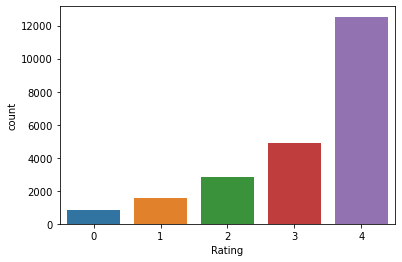

In [10]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
# Observar como está distribuido el dataset

sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [11]:
# Se reduce la cantidad de clases de salida agrupando los valores originales para ecualizar un poco el dataset
#  en 0 y 1 -> clase 0 
#  en 2 y 3 -> clase 1 
#  la clase 4 queda igual 
df_reviews.Rating.loc[df_reviews.Rating == 1] = 0
df_reviews.Rating.loc[df_reviews.Rating == 2] = 1
df_reviews.Rating.loc[df_reviews.Rating == 3] = 1
df_reviews.Rating.loc[df_reviews.Rating == 4] = 2


C:\Users\Marcelo\AppData\Local\Temp\ipykernel_23920\1684641606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews.Rating.loc[df_reviews.Rating == 1] = 0
C:\Users\Marcelo\AppData\Local\Temp\ipykernel_23920\1684641606.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews.Rating.loc[df_reviews.Rating == 2] = 1
C:\Users\Marcelo\AppData\Local\Temp\ipykernel_23920\1684641606.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [12]:
# Se analiza el balance de la salida

clases = df_reviews.Rating.value_counts()
clases_porciento = df_reviews.Rating.value_counts() * 100 /len(df_reviews)

#print(pd.DataFrame({'Dias': dias_de_lluvia, '(%)': dias_de_lluvia_porciento}))
print(pd.DataFrame({'cantidad': clases, '(%)': clases_porciento}))

   cantidad        (%)
2     12540  55.386246
1      7731  34.146018
0      2370  10.467736


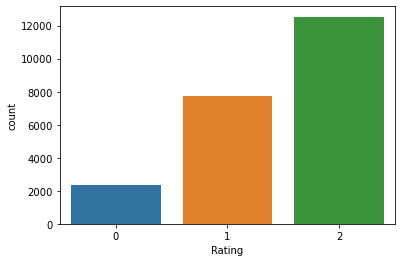

In [13]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
# Observar como está distribuido el dataset

sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [14]:
# Ejemplos de clase 0
print('Ejemplo de clase 0')
df_reviews['Review Text'].loc[df_reviews.Rating == 0][0:10]

Ejemplo de clase 0


5     I love tracy reese dresses, but this one is no...
22    First of all, this is not pullover styling. th...
26    I have been waiting for this sweater coat to s...
33    I ordered this 3 months ago, and it finally ca...
56    I am pregnant and i thought this would be a gr...
61    3 tags sewn in, 2 small (about 1'' long) and 1...
68    I really loved this top online and wanted to l...
71    Why do designers keep making crop tops??!! i c...
77    The zipper broke on this piece the first time ...
85    I was really hoping to like this, but it did n...
Name: Review Text, dtype: object

In [15]:
# Ejemplos de clase 1
print('Ejemplo de clase 1')
df_reviews['Review Text'].loc[df_reviews.Rating == 1][0:10]

Ejemplo de clase 1


0     Absolutely wonderful - silky and sexy and comf...
2     I had such high hopes for this dress and reall...
7     I ordered this in carbon for store pick up, an...
10    Dress runs small esp where the zipper area run...
14    This is a nice choice for holiday gatherings. ...
15    I took these out of the package and wanted the...
16    Material and color is nice.  the leg opening i...
20    If this product was in petite, i would get the...
21    I'm upset because for the price of the dress, ...
23    Cute little dress fits tts. it is a little hig...
Name: Review Text, dtype: object

In [16]:
# Ejemplos de clase 2
print('Ejemplo de clase 2')
df_reviews['Review Text'].loc[df_reviews.Rating == 2][0:10]

Ejemplo de clase 2


1     Love this dress!  it's sooo pretty.  i happene...
3     I love, love, love this jumpsuit. it's fun, fl...
4     This shirt is very flattering to all due to th...
6     I aded this in my basket at hte last mintue to...
8     I love this dress. i usually get an xs but it ...
9     I'm 5"5' and 125 lbs. i ordered the s petite t...
11    This dress is perfection! so pretty and flatte...
12    More and more i find myself reliant on the rev...
13    Bought the black xs to go under the larkspur m...
17    Took a chance on this blouse and so glad i did...
Name: Review Text, dtype: object

In [17]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [18]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

print(f'Hay {len(text_sequences)} filas para evaluar')

Hay 22641 filas para evaluar


In [19]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = ' '.join(text_sequences)

In [20]:
# Alumno: ¿Cuál es la longitud de ese corpus?

print(f'La longitud del corpus es {len(corpus)}')

La longitud del corpus es 7011643


In [21]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase

from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [22]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

print('** primeros 20 tokens **')
tokens[:20]

** primeros 20 tokens **


['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [23]:
# Alumno: ¿Cuántos tokens/palabras hay?

print(f'Hay {len(tokens)} tokens en el corpus')

Hay 1372203 tokens en el corpus


In [24]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.

from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)


In [25]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tok.word_index
print(f'Hay {len(word_index)} palabras en el vocabulario')

Hay 14847 palabras en el vocabulario


In [26]:
# Alumno: Convertir las palabras/tokens a números

sequences = tok.texts_to_sequences(text_sequences)

In [27]:
# Alumno: Determinar cual es la oración más larga

print(f'La oración mas larga tiene {max(len(s) for s in sequences)} palabas')

La oración mas larga tiene 115 palabas


In [28]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
#from tensorflow.keras.utils import pad_sequences

maxlen = 115

# Al realizar padding obtener la variable "X" (input)

X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [29]:
# Alumno: Observar las dimensiones de la variable input

X.shape

(22641, 115)

In [30]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

# Tomar la columna rating y alcemacenarla en una variable "y"
# Su shape debe ser equivalente la cantidad de rows del corpus

y = df_reviews['Rating'].values
print(f'Mínimo valor de y : {np.min(y)}, máximo valor de y : {np.max(y)}')
print(f'10 primeros valores de y sin onehot : \n{y[1:10]}')
y = to_categorical(y, num_classes=3)
print(f'10 primeros valores de y con onehot : \n{y[1:10]}')


Mínimo valor de y : 0, máximo valor de y : 2
10 primeros valores de y sin onehot : 
[2 1 2 2 0 2 1 2 2]
10 primeros valores de y con onehot : 
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [31]:
# Alumno: Dividir los datos en train y test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Alumno: determinar la dimensiones de entrada y salida

in_shape = X_train.shape[1] # max input sentence len
out_shape = 3 # clalificación de 0 a 4
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


In [33]:
print("X Train : ", X_train.shape)
print("X Test  : ", X_test.shape)
print("Y Train : ", y_train.shape)
print("Y Test  : ", y_test.shape)

X Train :  (18112, 115)
X Test  :  (4529, 115)
Y Train :  (18112, 3)
Y Test  :  (4529, 3)


### 2 - Entrenar el modelo con Embeddings + LSTM

In [34]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.

from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [35]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50

model.add(Embedding(input_dim=vocab_size+1, output_dim=300, input_length=in_shape))
model.add(Bidirectional(LSTM(units=8, return_sequences=True)))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(units=16))) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.9))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 300)          600300    
                                                                 
 bidirectional (Bidirectiona  (None, 115, 16)          19776     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 115, 16)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [36]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [37]:
# Se inicia la medición de tiempo de entrenamiento
inicio = time.time()

In [38]:
# Se entrena el modelo
# Se usan 5 epocas porque se vio que despues de la quinta epoca el accuracy deja de incrementarse
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 37s 71ms/step - loss: 0.5751 - accuracy: 0.5641 - val_loss: 0.4588 - val_accuracy: 0.6831
Epoch 2/5
453/453 [==============================] - 33s 74ms/step - loss: 0.5017 - accuracy: 0.6374 - val_loss: 0.4414 - val_accuracy: 0.6851
Epoch 3/5
453/453 [==============================] - 39s 85ms/step - loss: 0.4753 - accuracy: 0.6611 - val_loss: 0.4225 - val_accuracy: 0.6947
Epoch 4/5
453/453 [==============================] - 36s 80ms/step - loss: 0.4505 - accuracy: 0.6829 - val_loss: 0.4298 - val_accuracy: 0.6903
Epoch 5/5
453/453 [==============================] - 36s 80ms/step - loss: 0.4361 - accuracy: 0.6991 - val_loss: 0.4229 - val_accuracy: 0.6922


In [39]:
fin = time.time()
print(f'El entrenamiento tardó {round(fin-inicio,2)} segundos')

El entrenamiento tardó 181.19 segundos


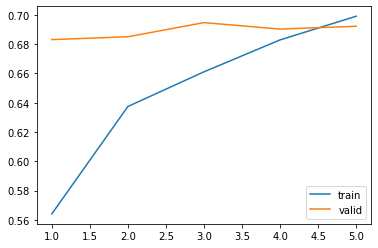

In [40]:

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### ** Evaluación del modelo ** 

In [41]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 18ms/step - loss: 0.4114 - accuracy: 0.7074


[0.41143444180488586, 0.7074409127235413]

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [42]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque

import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [43]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug('loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug('converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [44]:
model_fasttext = FasttextEmbeddings()

In [45]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [46]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 115, 64)          85248     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [47]:
# Se inicia la medición de tiempo de entrenamiento
inicio = time.time()

In [48]:
hist2 = model2.fit(X_train, y_train, epochs=7, validation_split=0.2)

Epoch 1/7
453/453 [==============================] - 48s 97ms/step - loss: 0.5719 - accuracy: 0.5489 - val_loss: 0.5502 - val_accuracy: 0.5476
Epoch 2/7
453/453 [==============================] - 46s 102ms/step - loss: 0.5474 - accuracy: 0.5590 - val_loss: 0.5387 - val_accuracy: 0.5504
Epoch 3/7
453/453 [==============================] - 48s 106ms/step - loss: 0.5364 - accuracy: 0.5678 - val_loss: 0.5320 - val_accuracy: 0.5683
Epoch 4/7
453/453 [==============================] - 50s 110ms/step - loss: 0.5276 - accuracy: 0.5775 - val_loss: 0.5200 - val_accuracy: 0.5829
Epoch 5/7
453/453 [==============================] - 50s 111ms/step - loss: 0.5188 - accuracy: 0.5856 - val_loss: 0.5147 - val_accuracy: 0.5912
Epoch 6/7
453/453 [==============================] - 52s 115ms/step - loss: 0.5106 - accuracy: 0.5958 - val_loss: 0.5092 - val_accuracy: 0.5932
Epoch 7/7
453/453 [==============================] - 52s 114ms/step - loss: 0.5038 - accuracy: 0.6031 - val_loss: 0.5075 - val_accuracy: 

In [49]:
fin = time.time()
print(f'El entrenamiento tardó {round(fin-inicio,2)} segundos')

El entrenamiento tardó 346.39 segundos


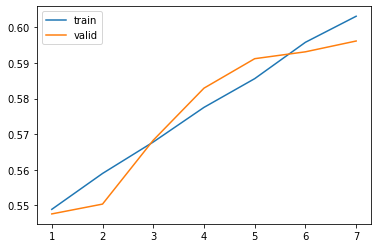

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

### ** Evaluación del modelo ** 

In [51]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 5s 33ms/step - loss: 0.4940 - accuracy: 0.6187


[0.4939865171909332, 0.6186796426773071]

### Conclusiones
El datset original tiene 5 clases y se ve que están muy desbalanceados. La clase mayoritaria (clase 4) tiene el 55% de los registros y la minoritaria (clase 0) tiene solo el 3.6% de los registros. Dado esta diferencia se descartó eliminar registros y llevar todos a 821 casos por clase. Decidí juntar la clase 0 con la 1 (quedando como clase 0) y la 2 con la 3 (quedando como clase 1), dejando la clase 4 sin cambios (quedando como clase 2). Este cambio no balanceó por completo el dataset pero lo mejoró significativamente, lo cual mejoró el entrenamiento del modelo. \
Entonces la clase 0 sería malo y regular, la clase 1 bueno y muy bueno y la clase 3 excelente/perfecto.

Distribución del Dataset original 

>Clase . . cant . . . (%) \
>4 . . . . 12540 . . 55.38\
>3 . . . . 4908 . .  21.67\
>2 . . . . 2823 . .  12.46\
>1 . . . . 1549 . . . 6.84\
>0 . . . . 821 . . .  3.62

Distribución del Dataset despues de juntar clases

>Clase . . cant . . . (%) \
>2 . . . . 12540 . . 55.38 \
>1 . . . .  7731 . . 34.14 \
>0 . . . .  2370 . . 10.46

Se utilizaron distintas configuraciones de redes buscando el mejor resultado.

Se hicieron dos pruebas. Una sin conexiones bidireccionales, y otra con conexiones bidireccionales. Los resultados fueron los siguientes:



**Con conexiones bidireccionales**\
Igual que en el caso anterior, se probó con y sin embeddings pre-entrenados. \
\
Para las pruebas con conexiones bidireccionales con embedding sin pre-entrenamiento se utilizó una red secuencial con una capa inicial de embedding de 300 unidades, una capa lstm bidireccional de 8 neuronas (16 neuronas) con dropoff de 60%, una capa lstm bidireccional de 16 neuronas (32 neuronas) con dropoff del 90% y una capa densa de 32 neuronas y por último una capa densa de 3 neuronas con funcion de antivación sigmoid. \
Con esta arquitectura y un entrenamiento de 5 épocas se logró un accuracy de 0.7074.\
El tiempo total de entrenamiento fue de 181 segundos (aproximadamente 36 segundos por época) \
\
Para las pruebas con conexiones bidireccionales con embedding pre-entrenado se utilizó una red secuencial con una capa inicial de embedding de 300 unidades, una capa lstm bidireccional de 32 neuronas (64 neuronas) con dropoff de 50%, una capa lstm bidireccional de 64 neuronas (128 neuronas) con dropoff del 50% y una capa densa de 32 neuronas y por último una capa densa de 3 neuronas con funcion de antivación sigmoid. \
Con esta arquitectura y un entrenamiento de 7 épocas se logró un accuracy de 0.6187.\
El tiempo total de entrenamiento fue de 346 segundos (aproximadamente 49 segundos por época)\
\
En todos los casos se entrenó con la cantidad de épocas indicadas ya que con mas épocas comenzaba a presentar overfeeting.\
\
Se ve que con capas lstm bidireccionales el accuracy es mejor que con las conexiones bidireccionales y que el entrenamiento se realiza en menor tiempo.\\

**Sin conexiones bidireccionales**\
Para esta prueba se utilizaron las mismas arquitecturas que las mensionadas en el punto anterior pero sin conexiones bidireccionales, obteniendo los siguientes resultados.\
\
Para la red con embedding sin pre-entrenamiento se obtuvo un accuracy de 0.7161 en 5 épocas (frente al accuracy de 0.7074 de la red sin conexiones bidireccionales). El tiempo de entrenamiento fue de 156 segundos (aproximadamente 31 segundos por época), frente a los 181 segundos de la red con conexiones bidireccionales. \
\
Para la red con embedding sin pre-entrenamiento se obtuvo un accuracy de 0.6083 en 7 épocas (frente al accuracy de 0.6187 de la red sin conexiones bidireccionales). El tiempo de entrenamiento fue de 266 segundos (aproximadamente 38 segundos por época), frente a los 346 segundos de la red con conexiones bidireccionales.\
